In [60]:
import h5py
import numpy as np

seg_path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/result_ecs-4x6x6-100K-40000-itr3-thd0.1_xml_m.h5"
pred_path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/test_ecs_synapse_polarity_full_margin_linear_leaky_f24_316_32_196000-cropped.h5"

In [9]:
with h5py.File(pred_path, "r") as fd:
    pred = fd[fd.keys()[0]][:]
with h5py.File(seg_path, "r") as fd:
    seg = fd[fd.keys()[0]][:]

In [7]:
pred.shape, seg.shape, pred.dtype, seg.dtype

((145, 1496, 1496), (145, 1496, 1496), dtype('uint32'), dtype('float32'))

In [178]:
abspred = (np.clip(np.abs(pred), 0, 1) * 255).astype(np.uint8)

In [4]:
gt_syn_path = "/n/coxfs01/data/ECS_iarpa201610_all_annotation/gt-4x6x6/synapse_groundtruth.h5"
with h5py.File(gt_syn_path, "r") as fd:
    gt_syn = fd[fd.keys()[0]][:]
gt_syn.shape

(145, 1496, 1496)

In [40]:
from scipy.ndimage import binary_dilation, label, binary_erosion
gt_syn_np, count = label(binary_dilation(gt_syn > 0, structure=np.ones((3, 7, 7), bool)))
count

103

In [41]:
match_synapses_by_overlap(gt_syn_np, syn_seg, 10)

(array([  0,   3,   8,   0,   9,  12,   0,   6,  22,  33,  30,  34,  36,
         37,  35,  40,  19,  42,  48,  49,  51,  50,  59,  61,  66,  56,
         69,  71,  73,   0,  74,  77,   0,  80,  85,  86,   0,  90,  88,
          0,  94,   0,   0,  92,  91,  93,   0,  99,  97,  96, 102,   0,
          0, 101,   0,   0,   0,   0, 106, 107, 108,   0,   0, 112, 114,
        116, 124, 113, 115, 119, 120, 118, 121, 122, 123,   0, 117,   0,
        127, 130,   0, 133, 148, 125, 131,   0,   0, 146,   0,   0, 142,
        139,   0,   0, 140, 144, 151,   0, 150,   0,   0, 149, 145,   0]),
 array([  0,   0,   0,   1,   0,   0,   7,   0,   2,   4,   0,   0,   5,
          0,   0,   0,   0,   0,   0,  16,   0,   0,   8,   0,   0,   0,
          0,   0,   0,   0,  10,   0,   0,   9,  11,  14,  12,  13,   0,
          0,  15,   0,  17,   0,   0,   0,   0,   0,  18,  19,  21,  20,
          0,   0,   0,   0,  25,   0,   0,  22,   0,  23,   0,   0,   0,
          0,  24,   0,   0,  26,   0,  27,   0,  

In [5]:
gt_seg_path = "/n/coxfs01/data/ECS_iarpa201610_all_annotation/gt-4x6x6/seg_groundtruth0.h5"
with h5py.File(gt_seg_path, "r") as fd:
    gt_seg = fd[fd.keys()[0]][:]
gt_seg.shape

(145, 1496, 1496)

In [12]:
img_path = "/n/coxfs01/data/ECS_iarpa201610_all_annotation/gt-4x6x6/gt-4x6x6_image.h5"
with h5py.File(img_path, "r") as fd:
    img = fd[fd.keys()[0]][:]
img.shape

(145, 1496, 1496)

In [11]:
from ariadne_microns_pipeline.algorithms.segmentation import segment_vesicle_style
from itertools import product
from ariadne_microns_pipeline.algorithms.evaluation import match_synapses_by_overlap
syn_seg = segment_vesicle_style(np.abs(pred) * 255, 2.0, 2.0, 128, 200, 15000, 1000, 3)

In [36]:
import pylab
from ipywidgets import interact
pylab.rcParams["figure.figsize"] = (12, 12)
def draw_synseg(idx):
    pylab.imshow(img[idx], cmap='gray')
    pylab.imshow(gt_syn_np[idx], cmap='tab20', alpha=.3)
    #pylab.imshow(pred[idx], alpha=.3)
    pylab.colorbar()
    pylab.show()
interact(draw_synseg, idx=(0, 144))

<function __main__.draw_synseg>

In [23]:
from scipy.sparse import coo_matrix

def connect_synapses(synapse, neuron, probs, xy_dilation=3, z_dilation=0, min_contact=25):
    volume_mask = (synapse != 0) & (neuron != 0)
    svoxels = synapse[volume_mask]
    nvoxels = neuron[volume_mask]
    #
    # Make a matrix of counts of voxels in both synapses and neurons
    # then extract synapse / neuron matches
    #
    matrix = coo_matrix(
        (np.ones(len(nvoxels), int), (svoxels, nvoxels)))
    matrix.sum_duplicates()
    maxsynapses = matrix.shape[1] + 1
    synapse_labels, neuron_labels = matrix.nonzero()
    counts = matrix.tocsr()[synapse_labels, neuron_labels].getA1()
    #
    # Filter neurons with too little overlap
    #
    mask = counts >= min_contact
    counts, neuron_labels, synapse_labels = [
        _[mask] for _ in counts, neuron_labels, synapse_labels]
    #
    # Order by synapse label and -count to get the neurons with
    # the highest count first
    #
    order = np.lexsort((-counts, synapse_labels))
    counts, neuron_labels, synapse_labels = \
        [_[order] for _ in counts, neuron_labels, synapse_labels]
    first = np.hstack(
        [[True], synapse_labels[:-1] != synapse_labels[1:], [True]])
    idx = np.where(first)[0]
    per_synapse_counts = idx[1:] - idx[:-1]
    #
    # Get rid of counts < 2
    #
    mask = per_synapse_counts >= 2
    idx = idx[:-1][mask]
    #
    # pick out the first and second most overlapping neurons and
    # their synapse.
    #
    neuron_1 = neuron_labels[idx]
    synapses = synapse_labels[idx]
    neuron_2 = neuron_labels[idx+1]
    #
    # Start by making a matrix to transform the map.
    #
    neuron_mapping = np.hstack(([0], neuron_1, neuron_2))
    matrix = coo_matrix(
        (np.arange(len(idx)*2) + 1,
         (np.hstack((neuron_1, neuron_2)),
          np.hstack((synapses, synapses)))),
        shape=(np.max(nvoxels)+1, np.max(svoxels) + 1)).tocsr()
    #
    # Convert the neuron / synapse map to the mapping labels
    #
    mapping_labeling = matrix[nvoxels, svoxels]
    #
    # Score each synapse / label overlap on both the transmitter
    # and receptor probabilities
    #
    areas = np.bincount(mapping_labeling.A1)
    total_scores = np.bincount(
        mapping_labeling.A1, probs[volume_mask])
    score_1 = total_scores[1:len(idx)+1]
    score_2 = total_scores[len(idx)+1:]
    #
    # Flip the scores and neuron assignments if score_2 > score_1
    #
    flippers = score_2 > score_1
    score_1[flippers], score_2[flippers] = \
        score_2[flippers], score_1[flippers]
    neuron_1[flippers], neuron_2[flippers] = \
        neuron_2[flippers], neuron_1[flippers]
    return synapses, neuron_1, neuron_2
np.column_stack(connect_synapses(syn_seg, seg, pred))

array([[    1, 50342, 50245],
       [    2, 38418, 49495],
       [    3, 45626, 49495],
       [    4, 34862, 40319],
       [    5, 19529, 15498],
       [    6, 30121, 50481],
       [    7,  9915,   219],
       [    8, 36380, 41026],
       [    9, 29061, 23626],
       [   10,   394,   358],
       [   11,  5956,  2218],
       [   12,   421,   358],
       [   14, 41807, 48213],
       [   15, 48639, 39335],
       [   16,   314,   358],
       [   17, 26703,   358],
       [   18, 41967, 39335],
       [   19,  5956,  2218],
       [   21, 19529, 19090],
       [   22,  7688,   358],
       [   23, 21367,   423],
       [   24, 14512, 15042],
       [   25,  9051, 14814],
       [   26,  9915,   219],
       [   27,  7749, 16721],
       [   28, 26518, 34090],
       [   29, 47558, 50168],
       [   30, 41677, 46238],
       [   32,   215,   108],
       [   33, 11017, 16513],
       [   35, 37504, 25483],
       [   36, 41739, 40319],
       [   37, 25832, 39335],
       [  

In [27]:
# Create a correspondence between the GT segmentation
# and the detected segmentation
#
mask = (gt_seg != 0) & (seg != 0)
gt_flat, seg_flat = [_[mask] for _ in gt_seg, seg]
matrix = coo_matrix((np.ones(gt_flat.shape, np.uint32), (seg_flat, gt_flat)))
matrix.sum_duplicates()
l_d, l_gt = matrix.nonzero()
count = matrix.tocsr()[l_d, l_gt].A1
#
# Now we find the counts that match the max for their detected label. 
# Ties go to whomever.
#
max_per_d = matrix.max(axis=1).toarray().flatten()
best = (count == max_per_d[l_d])
gt_per_seg = np.zeros(np.max(seg_flat)+1, np.uint32)
gt_per_seg[l_d[best]] = l_gt[best]
gt_per_seg[max_per_d == 0] = 0


In [25]:
gt_flat.shape, seg_flat.shape

((283401679,), (283401679,))

In [ ]:
import json
import tqdm
sigma_xy = np.linspace(.5, 10, 3)
sigma_z = np.linspace(.5, 4, 3)
threshold = np.linspace(80, 128, 3).astype(int)
min_size_2d = (np.linspace(10, 30, 3) ** 2).astype(int)
max_size_2d = np.array([15000])
min_size_3d = (np.linspace(20, 50, 3) ** 2).astype(int)
min_slice = np.arange(2, 5)
for isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice in \
    tqdm.tqdm(list(product(sigma_xy, sigma_z, threshold, min_size_2d, max_size_2d, min_size_3d, min_slice))):
    args = (np.abs(pred)*255, isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d,
            imin_size_3d, imin_slice)
    syn_seg = segment_vesicle_style(*args)
    detected_per_gt, gt_per_detected = match_synapses_by_overlap(gt_syn_np, syn_seg, 10)
    syn, neuron_1, neuron_2 = connect_synapses(syn_seg, seg, pred)
    path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_%.2f-%.2f-%d-%d-%d-%d-%d" % (
        isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice)
    with h5py.File(path+".h5", "w") as fd:
        fd.create_dataset("stack", data=syn_seg)
    d = dict(isigma_xy=isigma_xy, isigma_z=isigma_z, ithreshold=ithreshold, imin_size_2d=imin_size_2d,
             imax_size_2d=imax_size_2d, imin_size_3d=imin_size_3d, imin_slice=imin_slice,
             detected_per_gt = detected_per_gt.tolist(),
            gt_per_detected = gt_per_detected.tolist(),
            synapse=syn.tolist(),
            neuron_1=neuron_1.tolist(),
            neuron_2=neuron_2.tolist(),
            path=path+".h5")
    json.dump(d, open(path+".json", "w"))

 38%|███▊      | 277/729 [22:06:34<36:04:39, 287.34s/it]

In [30]:
np.sum(syn_seg)

0

In [77]:
def get_triplets(synapses, neurons):
    '''Get synapse, neuron, synapse triplets'''
    #
    # Sort the list by neuron-major, synapse-minor
    #
    order = np.lexsort((synapses, neurons))
    synapses, neurons = synapses[order], neurons[order]
    #
    # Get counts of # synapses per neuron
    #
    first = np.where(np.hstack([
        [True], neurons[1:] != neurons[:-1], [True]]))[0]
    counts=first[1:] - first[:-1]
    idx = first[:-1]
    #
    # Now there are (N * (N-1)) / 2 combinations for N synapses
    # attached to each neuron. We make tables for each N that do
    # the enumeration.
    #
    max_count = np.max(counts)
    tbl = np.zeros((max_count+1,
                    ((max_count * (max_count-1))/2),
                    2), int)
    for count in np.unique(counts):
        n = count * (count - 1) / 2
        if n == 0:
            continue
        a, b = np.mgrid[0:count, 0:count]
        a, b = a[a < b], b[a < b]
        tbl[count, :n, 0] = a
        tbl[count, :n, 1] = b
    #
    # The unique neurons:
    #
    first = first[:-1][counts > 1]
    uneurons = neurons[idx[counts > 1]]
    counts = counts[counts > 1]
    #
    # Create indices into above table
    #
    # neuron at index
    n_first = np.cumsum(np.hstack([[0], counts * (counts-1) / 2]))
    n_idx = np.zeros(n_first[-1], int)
    n_idx[n_first[1:-1]] = 1
    n_idx = np.cumsum(n_idx)
    #
    # synapse index
    #
    s_idx = np.arange(len(n_idx)) - n_first[n_idx]
    #
    # Use the combination table to read the offsets of the 
    # first and second synapses relative to the first occurence of
    # the neuron.
    #
    s1 = synapses[first[n_idx] + tbl[counts[n_idx], s_idx, 0]]
    s2 = synapses[first[n_idx] + tbl[counts[n_idx], s_idx, 1]]
    neuron = uneurons[n_idx]
    return s1, s2, neuron

gtl = np.unique(gt_syn_np[gt_syn_np != 0])
def synapse_statistics(path):
    #
    # Create all synapse-neuron-synapse triplets in the ground-truth
    #
    #
    # Get the detected synapses, mapping synapses to their gt
    # and neurons to their global labeling
    #
    s1_d = []
    s2_d = []
    n_d = []
    s_gt = []
    n_gt = []
    gt_labels = []
    tp_synapses = 0
    fp_synapses = 0
    fn_synapses = 0
    synapse_offset = 1
    synapse_map = []

    d_synapse_connections = json.load(open(path))
    #
    # The ground-truth synapse/neuron connections
    #
    gt_neuron = np.hstack([gt_neuron1, gt_neuron2])
    gt_synapse = np.hstack([gt_synapses]*2)
    #
    # The local label #s of the synapses. Doubled because each
    # synapse connects two neurons
    #
    l_synapse = np.hstack([d_synapse_connections["synapse"]] * 2)
    l_neuron = np.hstack([
        d_synapse_connections["neuron_1"],
        d_synapse_connections["neuron_2"]])
    #
    # map of gt synapses to detected
    #
    gt_per_detected = np.array(d_synapse_connections["gt_per_detected"])
    detected_per_gt = np.array(d_synapse_connections["detected_per_gt"])
    d_labels = np.arange(len(gt_per_detected)-1) + 1
    max_synapse = max(np.max(gt_synapse), len(detected_per_gt))
    global_synapse_labels = np.zeros(max_synapse + 1, int)
    global_synapse_labels[gtl] = \
        np.arange(len(gtl)) + synapse_offset
    synapse_offset += len(gtl)
    #
    # # of false synapses are those without correspondences
    # in the ground truth labels
    #
    fn_synapses += np.sum(detected_per_gt[gtl] == 0)
    tp_synapses += np.sum(gt_per_detected[d_labels] != 0)
    fp_synapses += np.sum(gt_per_detected[d_labels] == 0)
    to_keep = np.zeros(
        max(np.max(d_labels)+1, np.max(l_synapse))+1, bool)
    to_keep[d_labels] = True
    mask = to_keep[l_synapse]
    l_neuron = l_neuron[mask]
    l_synapse = l_synapse[mask]
    g_neuron = l_neuron
    #
    # Convert local synapse label # to the matching gt synapse
    # label #. Zero = no matching gt synapse.
    #
    # Note that there is no gt synapse with a label of zero,
    # so anything that pairs with a false positive synapse will
    # not be found in the true rendering of matching pairs.
    #
    g_synapse = global_synapse_labels[gt_per_detected[l_synapse]]
    #
    # Get the triples
    #
    s1_t, s2_t, n_t = get_triplets(g_synapse, g_neuron)
    #
    # Remove false positive detection <-> false positive detection
    #
    mask = (s1_t != 0) | (s2_t != 0)
    s1_t, s2_t, n_t = s1_t[mask], s2_t[mask], n_t[mask]
    s1_d.append(s1_t)
    s2_d.append(s2_t)
    n_d.append(n_t)
    #
    # Now do similar for gt_connections
    #
    gt_synapse = global_synapse_labels[gt_synapse]
    mask = gt_synapse != 0
    gt_synapse, gt_neuron = gt_synapse[mask], gt_neuron[mask]
    s_gt.append(gt_synapse)
    n_gt.append(gt_neuron)

    s_gt, n_gt = np.hstack(s_gt), np.hstack(n_gt)
    s1_d = np.hstack(s1_d)
    s2_d = np.hstack(s2_d)
    #
    # Make the detected matrix
    #
    d_matrix = coo_matrix((np.ones(len(s1_d)*2),
                           (np.hstack((s1_d, s2_d)),
                            np.hstack((s2_d, s1_d)))),
                          shape=(synapse_offset, synapse_offset)).tocsr()
    #
    # Make the gt matrix
    #
    s1_gt, s2_gt, n_gt = get_triplets(s_gt, n_gt)
    gt_matrix = coo_matrix((np.ones(len(s1_gt)*2),
                            (np.hstack((s1_gt, s2_gt)),
                             np.hstack((s2_gt, s1_gt)))),
                           shape=(synapse_offset, synapse_offset)).tocsr()
    #
    # Compile the results 
    #
    if len(s1_gt) == 0:
        true_positives = np.zeros(0, bool)
    else:
        true_positives = (d_matrix[s1_gt, s2_gt] != 0).A1
    tp_doublets = np.column_stack((s1_gt[true_positives],
                                   s2_gt[true_positives]))
    tp_doublets = tp_doublets[tp_doublets[:, 0] < tp_doublets[:, 1]]
    false_negatives = ~true_positives
    fn_doublets = np.column_stack((s1_gt[false_negatives],
                                   s2_gt[false_negatives]))
    fn_doublets = fn_doublets[fn_doublets[:, 0] < fn_doublets[:, 1]]
    if len(s1_d) == 0:
        false_positives = np.zeros(0, bool)
    else:
        false_positives = gt_matrix[s1_d, s2_d].A1 == 0
    fp_doublets = np.column_stack((s1_d[false_positives],
                                   s2_d[false_positives]))
    fp_doublets = fp_doublets[(fp_doublets[:, 0] < fp_doublets[:, 1]) &
                              (fp_doublets[:, 0] != 0)]
    n_true_positives = np.sum(true_positives)
    n_false_negatives = len(true_positives) - n_true_positives
    n_false_positives = np.sum(false_positives)
    precision = \
        float(n_true_positives) / \
        (n_true_positives + n_false_positives + np.finfo(float).eps)
    recall = \
        float(n_true_positives) / \
        (n_true_positives + n_false_negatives + np.finfo(float).eps)
    #
    # False negatives to add to pairs
    #
    s1_gt_fn = s1_gt[false_negatives]
    s2_gt_fn = s2_gt[false_negatives]
    #
    # Synapse stats
    #
    synapse_precision =\
        float(tp_synapses) / \
        (tp_synapses + fp_synapses + np.finfo(float).eps)
    synapse_recall = float(tp_synapses) /\
        (tp_synapses + fn_synapses + np.finfo(float).eps)
    result = dict(
        precision=precision,
        recall=recall,
        n_true_positives=n_true_positives,
        n_false_positives=n_false_positives,
        n_false_negatives=n_false_negatives,
        n_true_positive_synapses=tp_synapses,
        n_false_positive_synapses=fp_synapses,
        n_false_negative_synapses=fn_synapses,
        synapse_precision=synapse_precision,
        synapse_recall=synapse_recall,
        true_positive_labels=[_.tolist() for _ in tp_doublets],
        false_positive_labels=[_.tolist() for _ in fp_doublets],
        false_negative_labels=[_.tolist() for _ in fn_doublets])
    result.update(d_synapse_connections)
    return result

In [78]:
test_path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_0.50-0.50-104-100-15000-1225-2.json"
result = synapse_statistics(test_path)

In [81]:
sorted(result.keys())

[u'detected_per_gt',
 'false_negative_labels',
 'false_positive_labels',
 u'gt_per_detected',
 u'imax_size_2d',
 u'imin_size_2d',
 u'imin_size_3d',
 u'imin_slice',
 u'isigma_xy',
 u'isigma_z',
 u'ithreshold',
 'n_false_negative_synapses',
 'n_false_negatives',
 'n_false_positive_synapses',
 'n_false_positives',
 'n_true_positive_synapses',
 'n_true_positives',
 u'neuron_1',
 u'neuron_2',
 u'path',
 'precision',
 'recall',
 u'synapse',
 'synapse_map',
 'synapse_precision',
 'synapse_recall',
 'true_positive_labels']

In [83]:
import glob

keys = ("imin_size_2d", "imax_size_2d", "imin_size_3d", "imin_slice", "isigma_xy", "isigma_z",
        "ithreshold")
stats_dict = {}
for path in tqdm.tqdm(glob.glob("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/*.json")):
    result = synapse_statistics(path)
    key = tuple([result[k] for k in keys])
    stats_dict[key] = result

100%|██████████| 729/729 [00:13<00:00, 55.13it/s]


100%|██████████| 729/729 [00:00<00:00, 2359.10it/s]


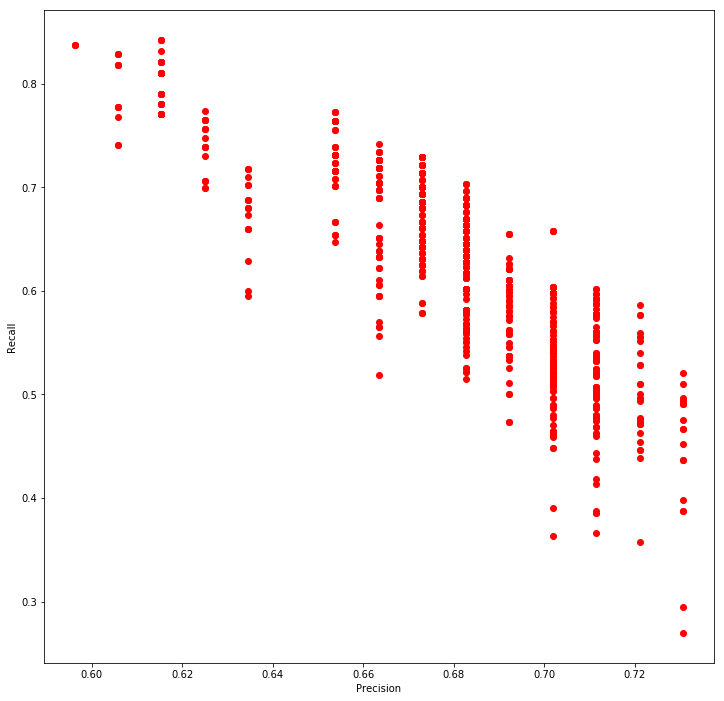

In [89]:
precision = []
recall = []
for path in tqdm.tqdm(glob.glob("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/*.json")):
    ddd = json.load(open(path))
    gt_per_detected = np.array(ddd["gt_per_detected"])
    detected_per_gt = np.array(ddd["detected_per_gt"])
    n_true_positives = np.sum(gt_per_detected > 0)
    n_false_positives = len(detected_per_gt) - n_true_positives
    n_false_negatives = len(gt_per_detected) - n_true_positives
    precision.append( float(n_true_positives) / (n_true_positives + n_false_positives))
    recall.append(float(n_true_positives) / (n_true_positives + n_false_negatives))
pylab.plot(precision, recall, "ro")
pylab.xlabel("Precision")
pylab.ylabel("Recall")
pylab.show()

In [91]:
result.keys()

['false_positive_labels',
 'true_positive_labels',
 'false_negative_labels',
 u'imin_slice',
 u'ithreshold',
 u'imin_size_3d',
 'precision',
 u'neuron_1',
 u'neuron_2',
 u'imax_size_2d',
 'n_false_positive_synapses',
 u'gt_per_detected',
 u'isigma_xy',
 'n_true_positive_synapses',
 u'synapse',
 'synapse_precision',
 'n_false_positives',
 'recall',
 u'detected_per_gt',
 'n_false_negatives',
 'synapse_recall',
 'n_true_positives',
 u'imin_size_2d',
 u'isigma_z',
 'synapse_map',
 u'path',
 'n_false_negative_synapses']

In [94]:
all_keys = list(keys) + ["n_true_positive_synapses", "n_false_negative_synapses", "n_false_positive_synapses", 
                         "synapse_precision", "synapse_recall",
                         "n_true_positives", "n_false_negatives", "n_false_positives",
                         "precision", "recall", "path"]
with open("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv", "w") as fd:
    fd.write('"' + ('","'.join(all_keys)) + '"\n')
    for result in stats_dict.values():
        first = True
        for key in all_keys:
            if first:
                first = False
            else:
                fd.write(",")
            value = result[key]
            if isinstance(value, basestring):
                value = '"%s"' % value
            else:
                value = str(value)
            fd.write(value)
        fd.write("\n")

In [95]:
! cat /n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv | head

"imin_size_2d","imax_size_2d","imin_size_3d","imin_slice","isigma_xy","isigma_z","ithreshold","n_true_positive_synapses","n_false_negative_synapses","n_false_positive_synapses","synapse_precision","synapse_recall","n_true_positives","n_false_negatives","n_false_positives","precision","recall","path"
900,15000,1225,2,0.5,2.25,80,74,29,58,0.560606060606,0.718446601942,108,162,180,0.375,0.4,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_0.50-2.25-80-900-15000-1225-2.h5"
100,15000,2500,4,5.25,0.5,104,73,30,58,0.557251908397,0.708737864078,108,162,157,0.407547169811,0.4,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_5.25-0.50-104-100-15000-2500-4.h5"
900,15000,1225,3,10.0,2.25,128,68,35,23,0.747252747253,0.660194174757,99,171,45,0.6875,0.366666666667,"/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-2.25-128-900-15000-1225-3.h5"
900,15000,1225,4,10.0,0.5,80,73,30,47,0.608333333333,0.708737864078,107,163,125,0.461206896552,0.3962962962

In [98]:
import pandas
pan = pandas.read_csv("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_statistics.csv")
pan

,imin_size_2d,imax_size_2d,imin_size_3d,imin_slice,isigma_xy,isigma_z,ithreshold,n_true_positive_synapses,n_false_negative_synapses,n_false_positive_synapses,synapse_precision,synapse_recall,n_true_positives,n_false_negatives,n_false_positives,precision,recall,path
0,900,15000,1225,2,0.50,2.25,80,74,29,58,0.560606,0.718447,108,162,180,0.375000,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
1,100,15000,2500,4,5.25,0.50,104,73,30,58,0.557252,0.708738,108,162,157,0.407547,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
2,900,15000,1225,3,10.00,2.25,128,68,35,23,0.747253,0.660194,99,171,45,0.687500,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
3,900,15000,1225,4,10.00,0.50,80,73,30,47,0.608333,0.708738,107,163,125,0.461207,0.396296,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
4,400,15000,400,2,0.50,4.00,80,71,32,58,0.550388,0.689320,106,164,154,0.407692,0.392593,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
5,100,15000,400,3,0.50,0.50,104,73,30,113,0.392473,0.708738,108,162,208,0.341772,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
6,900,15000,2500,2,10.00,0.50,128,68,35,36,0.653846,0.660194,100,170,81,0.552486,0.370370,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
7,400,15000,2500,3,0.50,4.00,128,65,38,26,0.714286,0.631068,80,190,69,0.536913,0.296296,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
8,100,15000,2500,4,0.50,2.25,80,74,29,71,0.510345,0.718447,108,162,201,0.349515,0.400000,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
9,400,15000,1225,3,0.50,0.50,80,75,28,92,0.449102,0.728155,111,159,207,0.349057,0.411111,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...


In [115]:
best = pan[(pan.synapse_precision>.78) & (pan.synapse_recall > .66)]
best

,imin_size_2d,imax_size_2d,imin_size_3d,imin_slice,isigma_xy,isigma_z,ithreshold,n_true_positive_synapses,n_false_negative_synapses,n_false_positive_synapses,synapse_precision,synapse_recall,n_true_positives,n_false_negatives,n_false_positives,precision,recall,path
128,900,15000,400,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
450,900,15000,2500,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...
645,900,15000,1225,4,10.0,4.0,104,68,35,19,0.781609,0.660194,99,171,45,0.6875,0.366667,/n/coxfs01/leek/dropbox/synapse_polarity_toufi...


In [129]:
best.iloc[0, -1]

'/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-4.00-104-900-15000-400-4.h5'

In [130]:
with h5py.File(best.iloc[0, -1], "r") as fd:
    sbest = fd["stack"][:]


In [151]:
dbest = json.load(open("/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_10.00-4.00-104-900-15000-400-4.json"))
gt_per_detected = np.array(dbest["gt_per_detected"])
detected_per_gt = np.array(dbest["detected_per_gt"])
i, j = np.mgrid[0:sbest.shape[1], 0:sbest.shape[2]].astype(np.float32)
def drawbest(idx, show_syn, show_pred, show_gt):
    pylab.imshow(img[idx], cmap='gray')
    if show_syn:
        pylab.imshow(sbest[idx], cmap='tab20', alpha=.3)
    if show_pred:
        pylab.imshow(pred[idx], alpha=.2)
    if show_gt:
        mapping = np.hstack(([0], np.random.RandomState(1234).permutation(300)+1))
        pylab.imshow(mapping[gtp[idx]], cmap='tab20', alpha=.2)
    darea = np.bincount(sbest[idx].flatten())
    darea[0] = 0
    di = np.bincount(sbest[idx].flatten(), i.flatten())
    dj = np.bincount(sbest[idx].flatten(), j.flatten())
    mysyn = np.where(darea > 0)[0]
    darea = darea[mysyn]
    di = di[mysyn] / darea
    dj = dj[mysyn] / darea
    for myid, myi, myj in zip(mysyn, di, dj):
        pylab.annotate("%d: %d" % (myid, gt_per_detected[myid]), (myj, myi))
    darea = np.bincount(gt_syn_np[idx].flatten())
    darea[0] = 0
    di = np.bincount(gt_syn_np[idx].flatten(), i.flatten())
    dj = np.bincount(gt_syn_np[idx].flatten(), j.flatten())
    mysyn = np.where(darea > 0)[0]
    darea = darea[mysyn]
    di = di[mysyn] / darea
    dj = dj[mysyn] / darea
    for myid, myi, myj in zip(mysyn, di, dj):
        if detected_per_gt[myid] == 0:
            pylab.annotate("fn: %d" % myid, (myj, myi))
    pylab.show() 
interact(drawbest, idx=(0, len(pred)-1), show_syn=True, show_pred=False, show_gt=False)
        

<function __main__.drawbest>

In [141]:
with h5py.File("/n/coxfs01/paragt/lee_data/R0-test-synapse_gt/ecs-syn-tst-groundtruth-polarity.h5", "r") as fd:
    gtp = fd[fd.keys()[0]][:]
gtp.shape

(145, 1496, 1496)

In [155]:
gtp[gtp != 0] = (gtp[gtp != 0] - 1) / 2

In [156]:
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gtp, sbest, 10)

In [160]:
float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1)

0.6542056074766355

In [161]:
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)

0.8045977011494253

In [148]:
len(gt_per_detected)

88

In [149]:
len(detected_per_gt)

217

In [153]:
np.min(gtp[gtp> 3])

4

In [159]:
dbest["synapse_precision"], dbest["synapse_recall"]

KeyError: 'synapse_precision'

In [210]:
isigma_xy = 15.0
isigma_z = 4.0
imin_size_2d = 900
imax_size_2d = 15000
imin_size_3d = 400
imin_slice = 4
ithreshold = 104
better = segment_vesicle_style(abspred, 
                               isigma_xy, 
                               isigma_z,
                               ithreshold, 
                               imin_size_2d,
                               imax_size_2d, 
                               imin_size_3d,
                               imin_slice)
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gt_syn_np, better, 10)
print float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1),\
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)
syn, neuron_1, neuron_2 = connect_synapses(better, seg, pred)
path = "/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_%.2f-%.2f-%d-%d-%d-%d-%d" % (
    isigma_xy, isigma_z, ithreshold, imin_size_2d, imax_size_2d, imin_size_3d, imin_slice)
with h5py.File(path+".h5", "w") as fd:
    fd.create_dataset("stack", data=better)
d = dict(isigma_xy=isigma_xy, isigma_z=isigma_z, ithreshold=ithreshold, imin_size_2d=imin_size_2d,
         imax_size_2d=imax_size_2d, imin_size_3d=imin_size_3d, imin_slice=imin_slice,
         detected_per_gt = detected_per_gt.tolist(),
        gt_per_detected = gt_per_detected.tolist(),
        synapse=syn.tolist(),
        neuron_1=neuron_1.tolist(),
        neuron_2=neuron_2.tolist(),
        path=path+".h5")
json.dump(d, open(path+".json", "w"))

0.650485436893 0.817073170732


In [208]:
detected_per_gt, gt_per_detected = match_synapses_by_overlap(gtp, better, 10)
float(np.sum(detected_per_gt > 0)) / (len(detected_per_gt) - 1),\
float(np.sum(gt_per_detected > 0)) / (len(gt_per_detected) - 1)

(0.6542056074766355, 0.8536585365853658)

In [184]:
map(lambda _:(_, dbest[_]), keys)

[('imin_size_2d', 900),
 ('imax_size_2d', 15000),
 ('imin_size_3d', 400),
 ('imin_slice', 4),
 ('isigma_xy', 10.0),
 ('isigma_z', 4.0),
 ('ithreshold', 104)]

In [211]:
path

'/n/coxfs01/leek/dropbox/synapse_polarity_toufiq/results/synapse_15.00-4.00-104-900-15000-400-4'

In [167]:
dbest["imin_size_2d"]

900

In [173]:
np.sum(better > 0)

0

In [175]:
help(segment_vesicle_style)

Help on function segment_vesicle_style in module ariadne_microns_pipeline.algorithms.segmentation:

segment_vesicle_style(prob, sigma_xy, sigma_z, threshold, min_size_2d, max_size_2d, min_size_3d, min_slice)
    Segment according to the "Vesicle" algorithm
    
    See http://arxiv.org/abs/1403.3724
    VESICLE: Volumetric Evaluation of Synaptic Interfaces using Computer
             vision at Large Scale
    William Gray Roncal, Michael Pekala, Verena Kaynig-Fittkau, 
    Dean M. Kleissas, Joshua T. Vogelstein, Hanspeter Pfister, Randal Burns, 
    R. Jacob Vogelstein, Mark A. Chevillet, Gregory D. Hager
    
    :param prob: The synapse probability volume with axes of z, y, and x
    :param sigma_xy: The sigma for the smoothing gaussian in the x and y
                     directions
    :param sigma_z: The sigma for the smoothing Gaussian in the z direction
    :param threshold: The probability threshold above which, a voxel is
                      deemed to be part of a synapse.
  

In [177]:
pred.max()

1.0954869